In [2]:
import pandas as pd

In [3]:
WORKDIR="/workdir/dwm269/scMuscle2"
os.chdir(WORKDIR)

In [4]:
meta = pd.read_csv("scMuscle2_metadata_v1-0.csv")
meta = meta.loc[meta["include"],] # remove unwanted metadata
# meta = meta[[x in ["fastq", "bam"] for x in meta["file.format"]]] # remove samples w/ download issues

# meta = meta[[x in ["muscle", "tendon"] for x in meta["tissue"]]] # subset by tissue 
# meta = meta[[x in ["Homo sapiens"] for x in meta["species"]]] # subset by species , "Mus musculus"
# meta = meta.iloc[[8,12,23,34,45],] # subset by row index

meta = meta[[x != "" for x in meta["GSM.accession"]]] # 
meta = meta[[x != "" for x in meta["sample"]]] # 

meta.index = list(range(0, len(meta))) # reset row indices

# Quick way to gather DOIs, given pubmed IDs/links

In [6]:
import requests
from bs4 import BeautifulSoup

# pubmed_url = f"https://pubmed.ncbi.nlm.nih.gov/{PMID}/"
def get_doi_from_pubmed(pubmed_url):
    response = requests.get(pubmed_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        doi_element = soup.find('a', {'data-ga-action': 'DOI'})

        if doi_element:
            return doi_element.text
        else:
            print("DOI not found.")
    else:
        print("Error fetching the PubMed page.")
        return None

In [ ]:
pubmed_url = "https://pubmed.ncbi.nlm.nih.gov/30760602/"
doi = get_doi_from_pubmed(pubmed_url)

if doi:
    print("DOI:", doi)

In [12]:
doi_list = []
for link in meta["manuscript.pubmed"]:
    if str(link).startswith('http'):
        doi = get_doi_from_pubmed(link)
        if doi:
            doi_list.append(doi)
        else:
            doi_list.append("Not found")
    else:
        # print("Invalid URL encountered:", link)
        doi_list.append("Not found")


DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
Error fetching the PubMed page.


In [15]:
print("DOIs retrieved:")
# for doi in doi_list:
for i in list(range(0,len(doi_list))):
    if("/" in doi):
        print(f"{meta['manuscript.pubmed'][i]} ||| {doi_list[i]}")

DOIs retrieved:
https://pubmed.ncbi.nlm.nih.gov/30283141/ ||| 
      10.1038/s41586-018-0590-4
    
https://pubmed.ncbi.nlm.nih.gov/30283141/ ||| 
      10.1038/s41586-018-0590-4
    
https://pubmed.ncbi.nlm.nih.gov/30283141/ ||| 
      10.1038/s41586-018-0590-4
    
https://pubmed.ncbi.nlm.nih.gov/30283141/ ||| 
      10.1038/s41586-018-0590-4
    
https://pubmed.ncbi.nlm.nih.gov/30283141/ ||| 
      10.1038/s41586-018-0590-4
    
https://pubmed.ncbi.nlm.nih.gov/30283141/ ||| 
      10.1038/s41586-018-0590-4
    
https://pubmed.ncbi.nlm.nih.gov/31809738/ ||| 
      10.1016/j.stem.2019.11.004
    
https://pubmed.ncbi.nlm.nih.gov/31809738/ ||| 
      10.1016/j.stem.2019.11.004
    
https://pubmed.ncbi.nlm.nih.gov/31809738/ ||| 
      10.1016/j.stem.2019.11.004
    
https://pubmed.ncbi.nlm.nih.gov/31809738/ ||| 
      10.1016/j.stem.2019.11.004
    
https://pubmed.ncbi.nlm.nih.gov/31809738/ ||| 
      10.1016/j.stem.2019.11.004
    
https://pubmed.ncbi.nlm.nih.gov/30922843/ ||| 
      10

# Identifying sex for each sample

In [5]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd

import random
import gc
import os
import seaborn as sns

In [6]:
WORKDIR="/workdir/dwm269/scMuscle2"
os.chdir(WORKDIR)
gc.enable()

In [9]:
mouse = sc.read_h5ad("data/atlas/mus_musculus_pp.h5ad")
mouse.shape

(1538623, 433)

In [10]:
from scripts.py.scantils import *
# from scripts.py.scanplots import *

In [12]:
# Compute average expression across groups
def average_expression_by_accession(adata, gene_name):
    # Check if the gene is in var_names
    if gene_name not in adata.var_names:
        print(f"{gene_name} not found in adata.var_names, checking adata.raw...")
        if gene_name not in adata.raw.var_names:
            print(f"{gene_name} not found in adata.raw.var_names")
            return
        else:
            print(f"{gene_name} found in adata.raw.var_names")
            gene_expression = adata.raw[:, gene_name].X.toarray()
    else:
        gene_expression = adata[:, gene_name].X.toarray()

    # Create a DataFrame with 'GSM.accession' and gene expression values
    expression_df = pd.DataFrame({'GSM.accession': adata.obs['GSM.accession'], 'expression': gene_expression.flatten()})
    
    # Compute the average expression of the gene per 'GSM.accession'
    average_expression = expression_df.groupby('GSM.accession')['expression'].mean()
    
    return average_expression

# Example usage
average_expression = average_expression_by_accession(mouse, 'Xist')
print(average_expression)


Xist not found in adata.var_names, checking adata.raw...
Xist found in adata.raw.var_names
GSM.accession
GSM2976778     0.002268
GSM2976779     0.000551
GSM2976780     0.001087
GSM2976781     0.000411
GSM2976782     0.000473
                 ...   
SRX12757379    0.001916
SRX12757380    0.006570
SRX12757381    0.014238
SRX12757382    0.004060
SRX12757383    0.007671
Name: expression, Length: 389, dtype: float32


Xist not found in adata.var_names, checking adata.raw...
Xist found in adata.raw.var_names


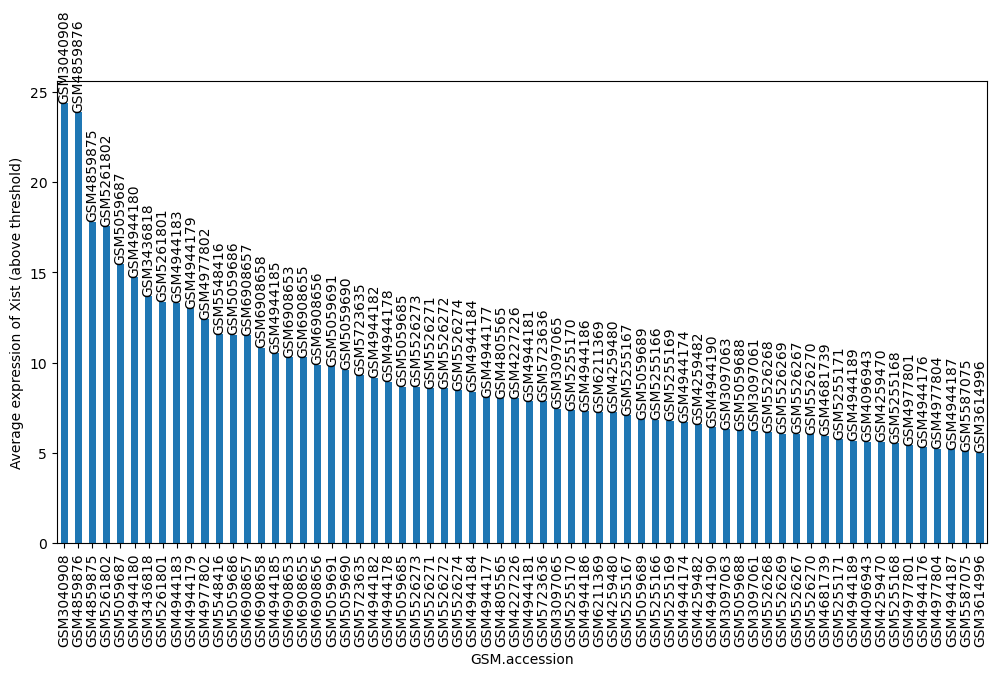

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def average_expression_by_accession_and_plot(adata, gene_name, threshold=5):
    # Check if the gene is in var_names
    if gene_name not in adata.var_names:
        print(f"{gene_name} not found in adata.var_names, checking adata.raw...")
        if gene_name not in adata.raw.var_names:
            print(f"{gene_name} not found in adata.raw.var_names")
            return None, None
        else:
            print(f"{gene_name} found in adata.raw.var_names")
            gene_expression = adata.raw[:, gene_name].X.toarray()
    else:
        gene_expression = adata[:, gene_name].X.toarray()

    # Create a DataFrame with 'GSM.accession' and gene expression values
    expression_df = pd.DataFrame({'GSM.accession': adata.obs['GSM.accession'], 'expression': gene_expression.flatten()})
    
    # Compute the average expression of the gene per 'GSM.accession'
    average_expression = expression_df.groupby('GSM.accession')['expression'].mean()
    
    # Filter the average expression based on the threshold and sort in descending order
    average_expression = average_expression[average_expression > threshold].sort_values(ascending=False)

    # Plot the average expression values above the threshold
    fig, ax = plt.subplots(figsize=(12, 6))
    average_expression.plot(kind='bar', ax=ax)
    ax.set_ylabel(f"Average expression of {gene_name} (above threshold)")
    ax.set_xlabel("GSM.accession")
    
    # Annotate the plot with 'GSM.accession' labels
    for i, (label, expression) in enumerate(average_expression.items()):
        ax.text(i, expression, label, ha='center', va='bottom', rotation=90)
    
    plt.show()

    return fig, average_expression.to_dict()

# Example usage
plot, avg_expression_dict = average_expression_by_accession_and_plot(mouse, 'Xist')


In [23]:

dict(sorted(avg_expression_dict.items(), key=lambda x: x[1]))

{'GSM3614996': 5.012204647064209,
 'GSM5587075': 5.101348876953125,
 'GSM4944187': 5.20723295211792,
 'GSM4977804': 5.220881462097168,
 'GSM4944176': 5.304624557495117,
 'GSM4977801': 5.4318366050720215,
 'GSM5255168': 5.529640197753906,
 'GSM4259470': 5.611791133880615,
 'GSM4096943': 5.612878799438477,
 'GSM4944189': 5.670579433441162,
 'GSM5255171': 5.768123626708984,
 'GSM4681739': 5.94093656539917,
 'GSM5526270': 6.042368412017822,
 'GSM5526267': 6.058554172515869,
 'GSM5526269': 6.073431968688965,
 'GSM5526268': 6.131700038909912,
 'GSM3097061': 6.238401889801025,
 'GSM5059688': 6.260725498199463,
 'GSM3097063': 6.32442045211792,
 'GSM4944190': 6.41035270690918,
 'GSM4259482': 6.598785400390625,
 'GSM4944174': 6.685943603515625,
 'GSM5255169': 6.774801731109619,
 'GSM5255166': 6.826519966125488,
 'GSM5059689': 6.859431266784668,
 'GSM5255167': 7.0752410888671875,
 'GSM4259480': 7.250680446624756,
 'GSM6211369': 7.2606706619262695,
 'GSM4944186': 7.294204235076904,
 'GSM5255170': 

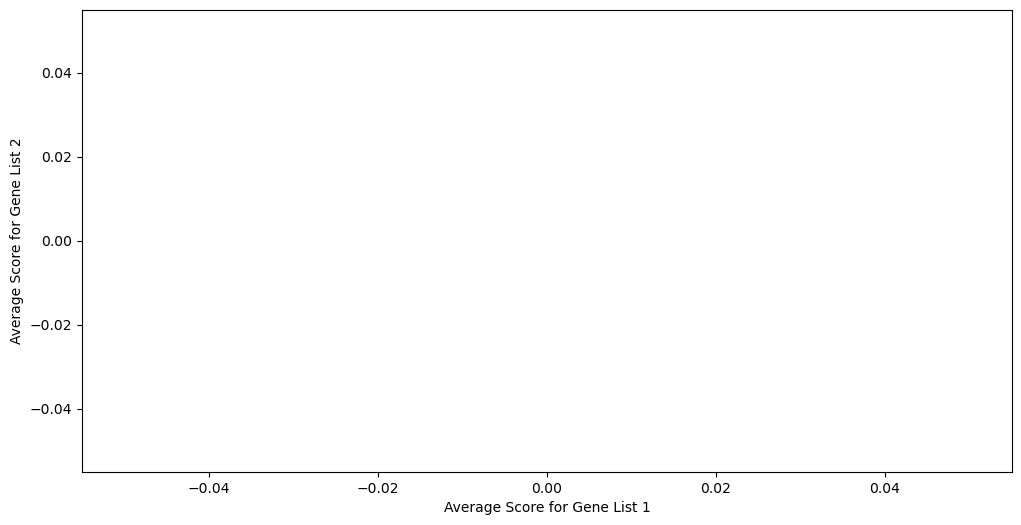

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def average_scores_by_accession_and_plot(adata, gene_list1, gene_list2):
    # Filter out genes not in adata.var_names
    gene_list1 = [gene for gene in gene_list1 if gene in adata.var_names]
    gene_list2 = [gene for gene in gene_list2 if gene in adata.var_names]
    
    # Compute average expression scores for each list of genes per 'GSM.accession'
    expression_df = pd.DataFrame(adata[:, gene_list1 + gene_list2].X.toarray(), columns=gene_list1 + gene_list2)
    expression_df['GSM.accession'] = adata.obs['GSM.accession']
    
    avg_scores = expression_df.groupby('GSM.accession').mean()
    
    avg_scores_list1 = avg_scores[gene_list1].mean(axis=1)
    avg_scores_list2 = avg_scores[gene_list2].mean(axis=1)
    
    # Plot the average scores for each 'GSM.accession' group
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(avg_scores_list1, avg_scores_list2)
    
    # Label each point with the 'GSM.accession' group
    for i, label in enumerate(avg_scores.index):
        ax.annotate(label, (avg_scores_list1[i], avg_scores_list2[i]))
    
    ax.set_xlabel('Average Score for Gene List 1')
    ax.set_ylabel('Average Score for Gene List 2')
    
    plt.show()

    return fig, (avg_scores_list1, avg_scores_list2)

# Example usage
gene_list1 = ['Xist', 'Gapdh', 'Pax7']
gene_list2 = ['Ccl2', 'Mmp9', 'Itga7']

plot, (avg_scores1, avg_scores2) = average_scores_by_accession_and_plot(mouse, gene_list1, gene_list2)


/home/dwm269/miniconda3/envs/scm2/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/home/dwm269/miniconda3/envs/scm2/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


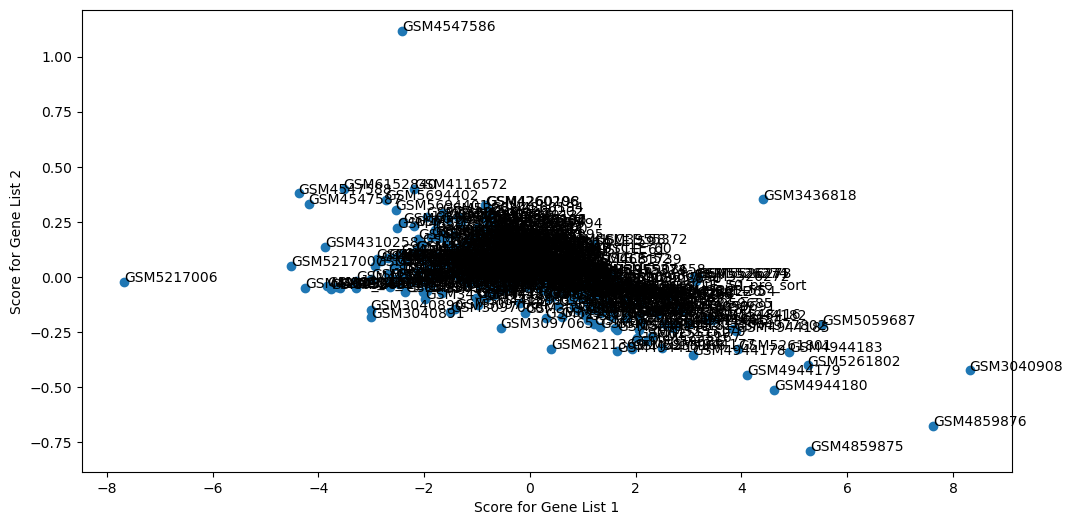

: 

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt

def score_genes_by_accession_and_plot(adata, gene_list1, gene_list2):
    adata_copy = adata.copy()
    
    # Score genes using scanpy.tl.score_genes
    sc.tl.score_genes(adata_copy, gene_list1, score_name='score_list1')
    sc.tl.score_genes(adata_copy, gene_list2, score_name='score_list2')

    # Group scores by 'GSM.accession'
    scores_df = adata_copy.obs[['GSM.accession', 'score_list1', 'score_list2']]
    grouped_scores = scores_df.groupby('GSM.accession').mean()

    # Plot the scores for each 'GSM.accession' group
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(grouped_scores['score_list1'], grouped_scores['score_list2'])

    # Label each point with the 'GSM.accession' group
    for i, label in enumerate(grouped_scores.index):
        ax.annotate(label, (grouped_scores['score_list1'][i], grouped_scores['score_list2'][i]))

    ax.set_xlabel('Score for Gene List 1')
    ax.set_ylabel('Score for Gene List 2')

    plt.show()

    return fig, grouped_scores

# Example usage
gene_female = ['Xist', 'Tsix']
gene_male = ['Sry', 'Ddx3y', 'Cdy1', 'Usp9y','Zfy']

plot, scores = score_genes_by_accession_and_plot(
    mouse, 
    gene_female, 
    gene_male
)

